<a href="https://colab.research.google.com/github/noorelhaj98-ship-it/pytorch-tutorial/blob/main/gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Step 1: Dataset Selection



In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd


In [42]:
!pip install torch torchvision


In [43]:


df = pd.read_csv("/content/Titanic-Dataset.csv")
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [44]:
#summary table
class_counts = df['Survived'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

class_counts['Class'] = class_counts['Class'].map({
    0: 'Did Not Survive',
    1: 'Survived'
})

class_counts['Percentage'] = (
    class_counts['Count'] / class_counts['Count'].sum() * 100
).round(2)

class_counts


,Class,Count,Percentage
0,Did Not Survive,549,61.62
1,Survived,342,38.38


In [45]:
df.columns


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [46]:
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])


In [47]:
df['Age'] = df['Age'].fillna(df['Age'].median())


In [48]:
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])


In [49]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})


In [50]:
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)


In [51]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked_Q  891 non-null    bool   
 8   Embarked_S  891 non-null    bool   
dtypes: bool(2), float64(2), int64(5)
memory usage: 50.6 KB


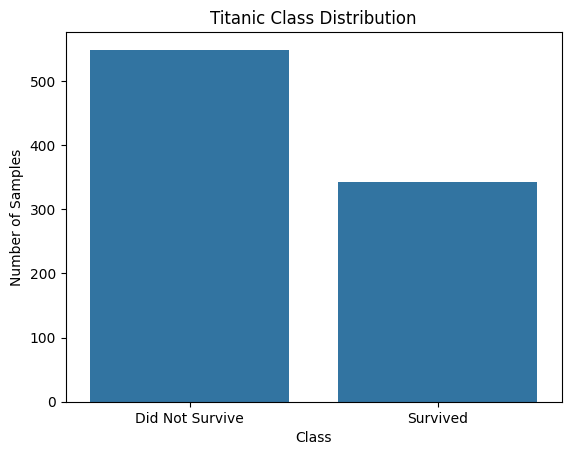

In [52]:
#Bar plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.countplot(x='Survived', data=df)
plt.xticks([0, 1], ['Did Not Survive', 'Survived'])
plt.title("Titanic Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()


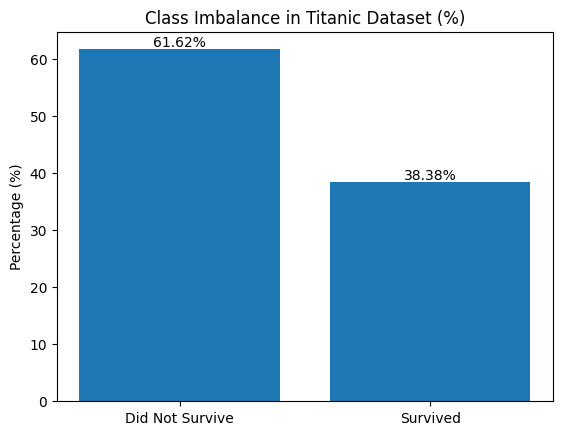

In [53]:
#Bar plot
plt.figure()
plt.bar(class_counts['Class'], class_counts['Percentage'])

plt.title("Class Imbalance in Titanic Dataset (%)")
plt.ylabel("Percentage (%)")

for i, v in enumerate(class_counts['Percentage']):
    plt.text(i, v + 0.5, f"{v}%", ha='center')

plt.show()


Step 2: GAN Implementation

In [56]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

# Ensure all data is numeric
minority_df = df[df['Survived'] == 1].drop(columns=['Survived'])
minority_df = minority_df.astype(float)

# Convert to PyTorch tensor
X_minority = torch.tensor(minority_df.values, dtype=torch.float32)

# Number of features
data_dim = X_minority.shape[1]
noise_dim = 16

# Labels tensor for CGAN
labels = torch.ones(X_minority.shape[0], 1)


In [57]:
class Generator(nn.Module):
    def __init__(self, noise_dim, data_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, data_dim)
        )

    def forward(self, z):
        return self.model(z)


In [58]:
class Discriminator(nn.Module):
    def __init__(self, data_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [59]:
generator = Generator(noise_dim, data_dim)
discriminator = Discriminator(data_dim)

criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)


In [60]:
epochs = 1000
batch_size = 32

for epoch in range(epochs):
    idx = np.random.randint(0, X_minority.shape[0], batch_size)
    real_data = X_minority[idx]

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    # Train Discriminator
    z = torch.randn(batch_size, noise_dim)
    fake_data = generator(z)
    D_real = discriminator(real_data)
    D_fake = discriminator(fake_data.detach())
    loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)
    optimizer_D.zero_grad()
    loss_D.backward()
    optimizer_D.step()

    # Train Generator
    z = torch.randn(batch_size, noise_dim)
    fake_data = generator(z)
    D_fake = discriminator(fake_data)
    loss_G = criterion(D_fake, real_labels)
    optimizer_G.zero_grad()
    loss_G.backward()
    optimizer_G.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")


Epoch 0 | D Loss: 1.3203 | G Loss: 0.6847
Epoch 200 | D Loss: 0.6439 | G Loss: 0.7821
Epoch 400 | D Loss: 0.4034 | G Loss: 1.2865
Epoch 600 | D Loss: 0.3927 | G Loss: 1.5690
Epoch 800 | D Loss: 0.5677 | G Loss: 1.5176


In [61]:
num_synthetic = len(df[df['Survived']==0]) - len(df[df['Survived']==1])
z = torch.randn(num_synthetic, noise_dim)
synthetic_data = generator(z).detach().numpy()

synthetic_df = pd.DataFrame(synthetic_data, columns=minority_df.columns)
synthetic_df['Survived'] = 1

balanced_df_vanilla = pd.concat([df, synthetic_df], ignore_index=True)
balanced_df_vanilla['Survived'].value_counts()


,count
Survived,
0,549
1,549


In [62]:
class CGAN_Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, data_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, data_dim)
        )
    def forward(self, noise, labels):
        x = torch.cat([noise, labels], dim=1)
        return self.model(x)


In [63]:
class CGAN_Discriminator(nn.Module):
    def __init__(self, data_dim, label_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim + label_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, data, labels):
        x = torch.cat([data, labels], dim=1)
        return self.model(x)


In [64]:
label_dim = 1
generator_cgan = CGAN_Generator(noise_dim, label_dim, data_dim)
discriminator_cgan = CGAN_Discriminator(data_dim, label_dim)

optimizer_G_cgan = torch.optim.Adam(generator_cgan.parameters(), lr=0.0002)
optimizer_D_cgan = torch.optim.Adam(discriminator_cgan.parameters(), lr=0.0002)


In [65]:
epochs = 1000
batch_size = 32

for epoch in range(epochs):
    idx = np.random.randint(0, X_minority.shape[0], batch_size)
    real_data = X_minority[idx]
    real_labels = labels[idx]

    # Train Discriminator
    z = torch.randn(batch_size, noise_dim)
    fake_data = generator_cgan(z, real_labels)
    D_real = discriminator_cgan(real_data, real_labels)
    D_fake = discriminator_cgan(fake_data.detach(), real_labels)
    loss_D = nn.BCELoss()(D_real, torch.ones_like(D_real)) + nn.BCELoss()(D_fake, torch.zeros_like(D_fake))
    optimizer_D_cgan.zero_grad()
    loss_D.backward()
    optimizer_D_cgan.step()

    # Train Generator
    z = torch.randn(batch_size, noise_dim)
    fake_data = generator_cgan(z, real_labels)
    D_fake = discriminator_cgan(fake_data, real_labels)
    loss_G = nn.BCELoss()(D_fake, torch.ones_like(D_fake))
    optimizer_G_cgan.zero_grad()
    loss_G.backward()
    optimizer_G_cgan.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")
v

Epoch 0 | D Loss: 1.9726 | G Loss: 0.7236
Epoch 200 | D Loss: 0.6622 | G Loss: 0.8238
Epoch 400 | D Loss: 0.5259 | G Loss: 1.2542
Epoch 600 | D Loss: 0.6390 | G Loss: 1.4529
Epoch 800 | D Loss: 0.4948 | G Loss: 1.8924


38.38

In [66]:
num_synthetic = len(df[df['Survived']==0]) - len(df[df['Survived']==1])
z = torch.randn(num_synthetic, noise_dim)
labels_input = torch.ones(num_synthetic, 1)
synthetic_data_cgan = generator_cgan(z, labels_input).detach().numpy()

synthetic_df_cgan = pd.DataFrame(synthetic_data_cgan, columns=minority_df.columns)
synthetic_df_cgan['Survived'] = 1

balanced_df_cgan = pd.concat([df, synthetic_df_cgan], ignore_index=True)
balanced_df_cgan['Survived'].value_counts()


,count
Survived,
0,549
1,549


In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Function to prepare X and y
def prepare_data(df):
    X = df.drop(columns=['Survived']).values
    y = df['Survived'].values
    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

# Original
X_orig, y_orig = prepare_data(df)

# Vanilla GAN balanced
X_vanilla, y_vanilla = prepare_data(balanced_df_vanilla)

# CGAN balanced
X_cgan, y_cgan = prepare_data(balanced_df_cgan)


Step 3: Data Augmentation & Classification

In [69]:
from sklearn.model_selection import train_test_split

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_orig, y_orig, test_size=0.2, random_state=42
)
X_train_vanilla, X_test_vanilla, y_train_vanilla, y_test_vanilla = train_test_split(
    X_vanilla, y_vanilla, test_size=0.2, random_state=42
)
X_train_cgan, X_test_cgan, y_train_cgan, y_test_cgan = train_test_split(
    X_cgan, y_cgan, test_size=0.2, random_state=42
)


In [71]:
train_loaders = {
    'Original': create_dataloader(X_train_orig, y_train_orig, batch_size),
    'Vanilla GAN': create_dataloader(X_train_vanilla, y_train_vanilla, batch_size),
    'CGAN': create_dataloader(X_train_cgan, y_train_cgan, batch_size)
}

# Optional: Test sets for evaluation
test_sets = {
    'Original': (X_test_orig, y_test_orig),
    'Vanilla GAN': (X_test_vanilla, y_test_vanilla),
    'CGAN': (X_test_cgan, y_test_cgan)
}


In [72]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [73]:
def train_model(model, dataloader, epochs=50, lr=0.001):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
    return model


In [74]:
input_dim = X_orig.shape[1]
models = {}

for key, loader in train_loaders.items():
    model = MLPClassifier(input_dim)
    models[key] = train_model(model, loader)
    print(f"{key} model trained.")


Original model trained.
Vanilla GAN model trained.
CGAN model trained.


In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, X, y):
    model.eval()
    X_tensor = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        y_pred = model(X_tensor).numpy()
    y_pred_label = (y_pred > 0.5).astype(int)

    return {
        'Accuracy': accuracy_score(y, y_pred_label),
        'Precision': precision_score(y, y_pred_label),
        'Recall': recall_score(y, y_pred_label),
        'F1-Score': f1_score(y, y_pred_label),
        'AUC-ROC': roc_auc_score(y, y_pred_label)
    }

# Evaluate each model
results = {}
for key, model in models.items():
    X_test, y_test = test_sets[key]
    results[key] = evaluate_model(model, X_test, y_test)

results_df = pd.DataFrame(results).T
results_df


,Accuracy,Precision,Recall,F1-Score,AUC-ROC
Original,0.826816,0.841270,0.716216,0.773723,0.810489
Vanilla GAN,0.859091,0.890909,0.837607,0.863436,0.860551
CGAN,0.863636,0.899083,0.837607,0.867257,0.865405


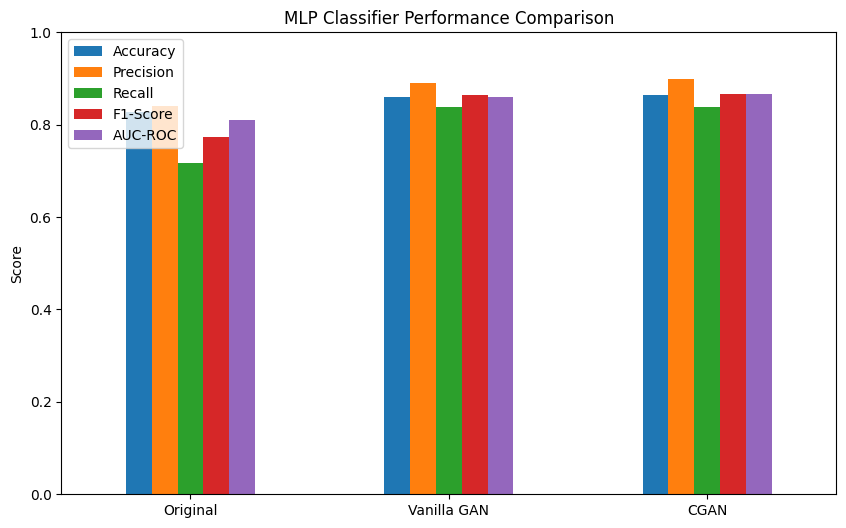

In [76]:
import matplotlib.pyplot as plt

results_df.plot(kind='bar', figsize=(10,6))
plt.title("MLP Classifier Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.show()


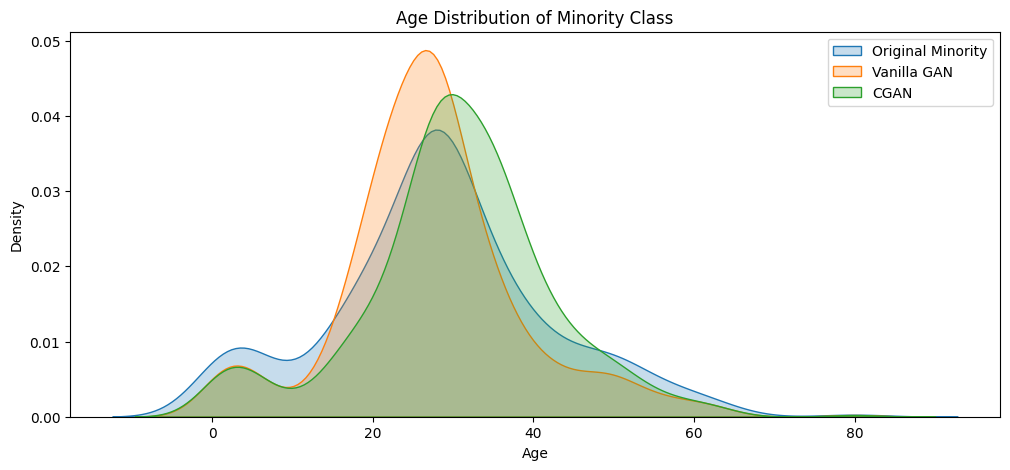

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compare Age distribution as an example
plt.figure(figsize=(12,5))
sns.kdeplot(df[df['Survived']==1]['Age'], label='Original Minority', fill=True)
sns.kdeplot(balanced_df_vanilla[balanced_df_vanilla['Survived']==1]['Age'], label='Vanilla GAN', fill=True)
sns.kdeplot(balanced_df_cgan[balanced_df_cgan['Survived']==1]['Age'], label='CGAN', fill=True)
plt.title('Age Distribution of Minority Class')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()


Step 4: Evaluation

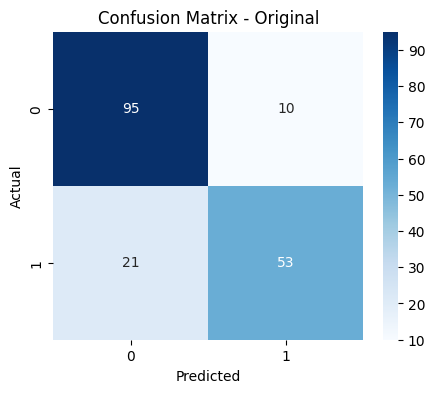

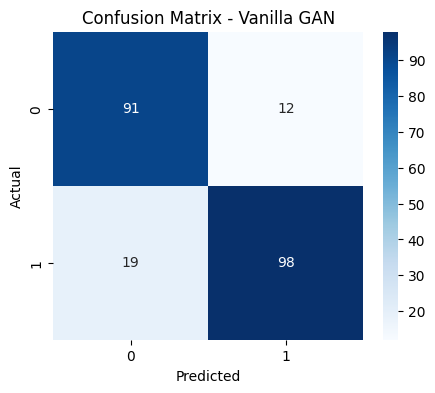

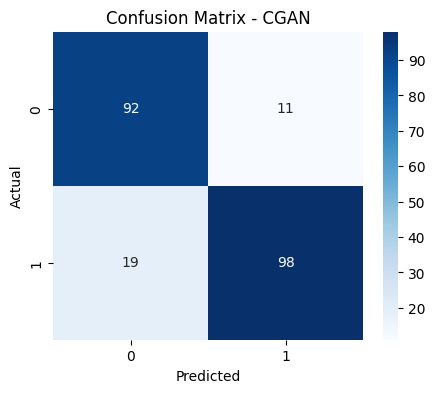

In [78]:
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, X, y, title):
    model.eval()
    X_tensor = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        y_pred = model(X_tensor).numpy()
    y_pred_label = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(y, y_pred_label)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

for key, model in models.items():
    X_test, y_test = test_sets[key]
    plot_confusion_matrix(model, X_test, y_test, f'Confusion Matrix - {key}')


In [79]:
results_df


,Accuracy,Precision,Recall,F1-Score,AUC-ROC
Original,0.826816,0.841270,0.716216,0.773723,0.810489
Vanilla GAN,0.859091,0.890909,0.837607,0.863436,0.860551
CGAN,0.863636,0.899083,0.837607,0.867257,0.865405


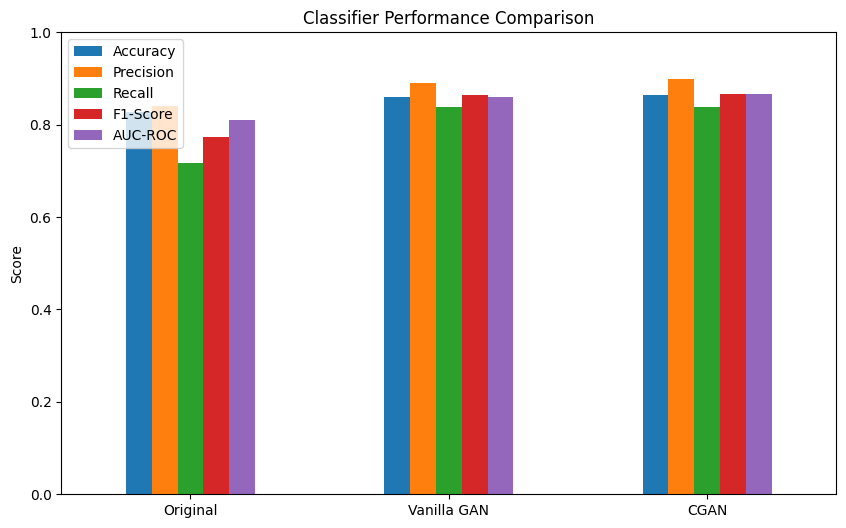

In [80]:
results_df.plot(kind='bar', figsize=(10,6))
plt.title("Classifier Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.show()


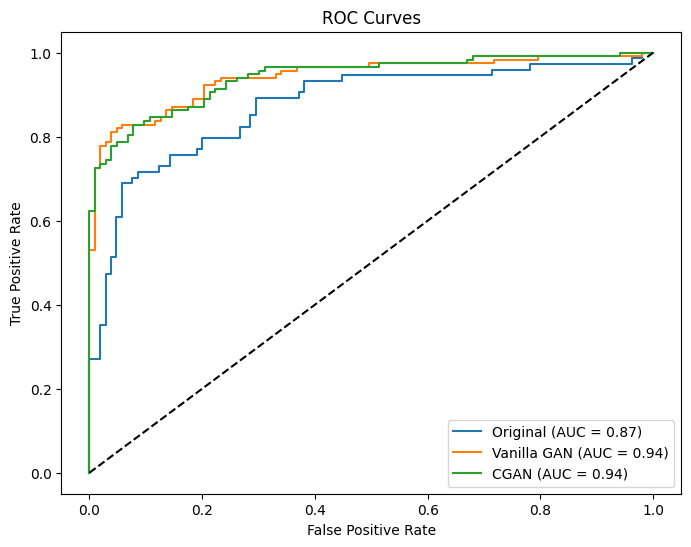

In [81]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for key, model in models.items():
    X_test, y_test = test_sets[key]
    model.eval()
    X_tensor = torch.tensor(X_test, dtype=torch.float32)
    with torch.no_grad():
        y_pred = model(X_tensor).numpy()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{key} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
